![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Format meteo data for EddyPro flux processing
</b>
</span>

---
**Notebook version**: `1` (24 Feb 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Formats meteo data to be used in EddyPro flux processing

More info:
- [EddyPro help: Supported biomet file formats](https://www.licor.com/support/EddyPro/topics/biomet-data-format.html)

</br>

# **Settings**

## Variables

In [6]:
# Name of the variables in the original data file
SW_IN = 'SW_IN_T1_47_1_gfXG'
RH = 'RH_T1_47_1'
PPFD_IN = 'PPFD_IN_T1_47_1_gfXG'
LW_IN = 'LW_IN_T1_47_1'
TA = 'TA_T1_47_1_gfXG'
PA = 'PA_T1_47_1'

# Rename original variables for EddyPro, and add units
rename_dict = {
    TA: ('Ta_1_1_1', 'C'),
    SW_IN: ('Rg_1_1_1', 'W+1m-2'),
    RH: ('RH_1_1_1', '%'),
    LW_IN: ('Lwin_1_1_1', 'W+1m-2'),
    PA: ('Pa_1_1_1', 'kPa'),
    PPFD_IN: ('PPFD_1_1_1', 'umol+1m-2s-1'),
}

</br>

# **Imports**

In [7]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from dbc_influxdb import dbcInflux

from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # For plotting heatmaps
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.formats.meteo import FormatMeteoForEddyProFluxProcessing  # Class to format output files for upload
from diive.core.io.files import load_parquet, save_parquet

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.0


</br>

# **Docstring**

In [8]:
# help(FormatMeteoForEddyProProcessing)

</br>

# **Load data**

In [16]:
SOURCEFILE = r"../10_METEO/12.5_METEO7_GAPFILLED_2004-2024.parquet"
df = load_parquet(filepath=SOURCEFILE)
keepcols = ['SW_IN_T1_47_1_gfXG', 'RH_T1_47_1', 'PPFD_IN_T1_47_1_gfXG', 'LW_IN_T1_47_1', 'TA_T1_47_1_gfXG', 'PA_T1_47_1']
df = df[keepcols].copy()

Loaded .parquet file ../10_METEO/12.5_METEO7_GAPFILLED_2004-2024.parquet (0.027 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


The dataframe with original data looks like this:

In [17]:
df

,SW_IN_T1_47_1_gfXG,RH_T1_47_1,PPFD_IN_T1_47_1_gfXG,LW_IN_T1_47_1,TA_T1_47_1_gfXG,PA_T1_47_1
TIMESTAMP_MIDDLE,,,,,,
2004-09-20 10:45:00,602.874084,80.503701,1070.543364,NaN,13.300000,NaN
2004-09-20 11:15:00,703.762207,77.503701,881.543364,NaN,13.390000,NaN
2004-09-20 11:45:00,537.947327,75.803704,1022.543364,NaN,13.810000,NaN
2004-09-20 12:15:00,634.747437,71.503701,1284.543364,NaN,14.470000,NaN
2004-09-20 12:45:00,634.747437,72.703705,742.543364,NaN,13.980000,NaN
...,...,...,...,...,...,...
2024-12-31 21:45:00,0.000000,87.254008,0.000000,232.595527,-0.504794,94.211806
2024-12-31 22:15:00,0.000000,87.430236,0.000000,232.609777,-0.296828,94.189013
2024-12-31 22:45:00,0.000000,89.787920,0.000000,232.345020,-0.392922,94.169525


</br>

# **Apply formatting**

In [18]:
f = FormatMeteoForEddyProFluxProcessing(
    df=df,
    cols=rename_dict
)
f.run()


Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2004-09-20 10:45:00 and 2024-12-31 23:45:00 ...
Splitting timestamp into two separate columns ('TIMESTAMP_1', 'yyyy-mm-dd') and ('TIMESTAMP_2', 'HH:MM')
Filling missing values with -9999 ...
Renaming columns ...


In [19]:
res = f.get_results()
res

,TIMESTAMP_1,TIMESTAMP_2,Rg_1_1_1,RH_1_1_1,PPFD_1_1_1,Lwin_1_1_1,Ta_1_1_1,Pa_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,umol+1m-2s-1,W+1m-2,C,kPa
TIMESTAMP_MIDDLE,,,,,,,,
2004-09-20 10:45:00,2004-09-20,10:45,602.874084,80.503701,1070.543364,-9999.000000,13.300000,-9999.000000
2004-09-20 11:15:00,2004-09-20,11:15,703.762207,77.503701,881.543364,-9999.000000,13.390000,-9999.000000
2004-09-20 11:45:00,2004-09-20,11:45,537.947327,75.803704,1022.543364,-9999.000000,13.810000,-9999.000000
2004-09-20 12:15:00,2004-09-20,12:15,634.747437,71.503701,1284.543364,-9999.000000,14.470000,-9999.000000
2004-09-20 12:45:00,2004-09-20,12:45,634.747437,72.703705,742.543364,-9999.000000,13.980000,-9999.000000
...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,2024-12-31,21:45,0.000000,87.254008,0.000000,232.595527,-0.504794,94.211806
2024-12-31 22:15:00,2024-12-31,22:15,0.000000,87.430236,0.000000,232.609777,-0.296828,94.189013


</br>

# **Plot all variables**

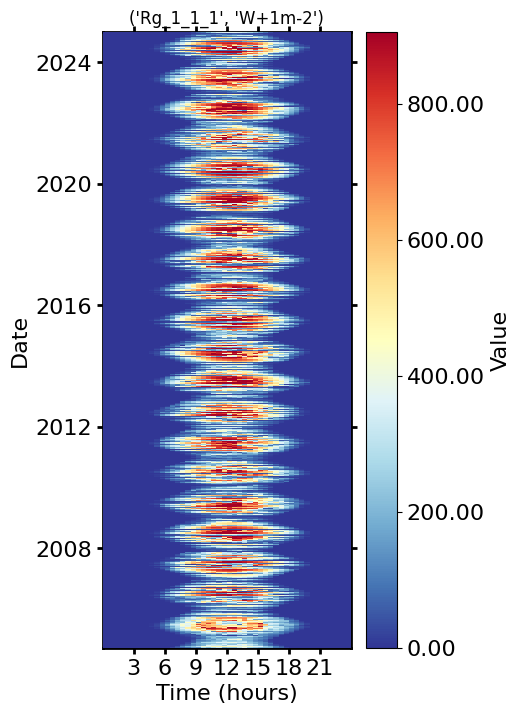

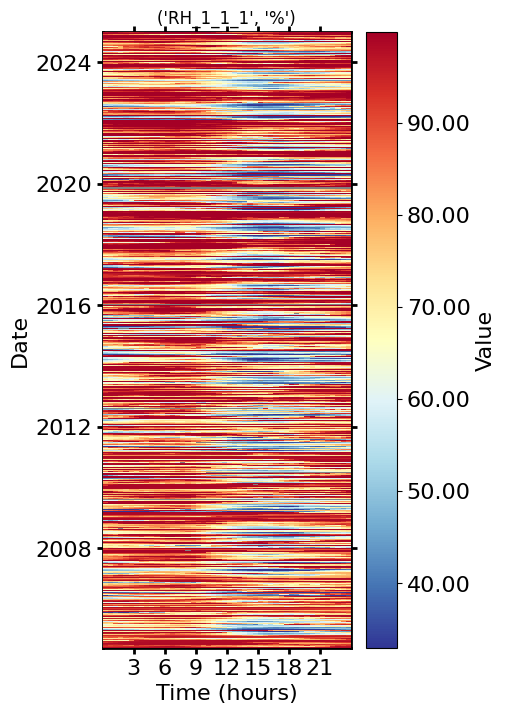

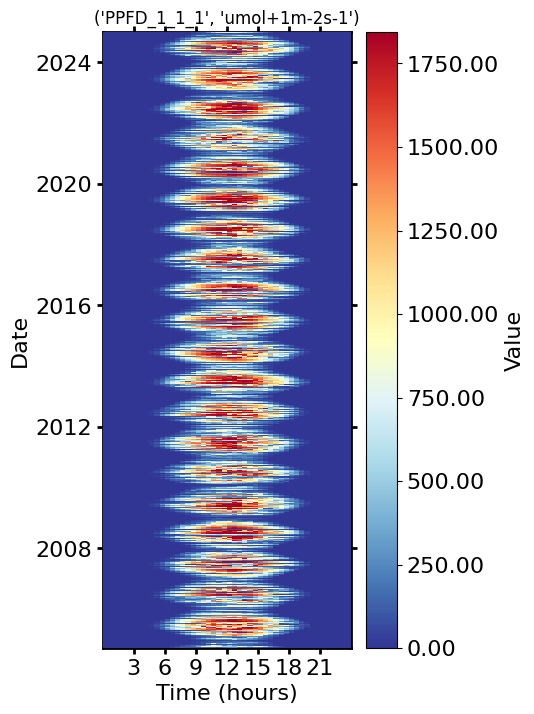

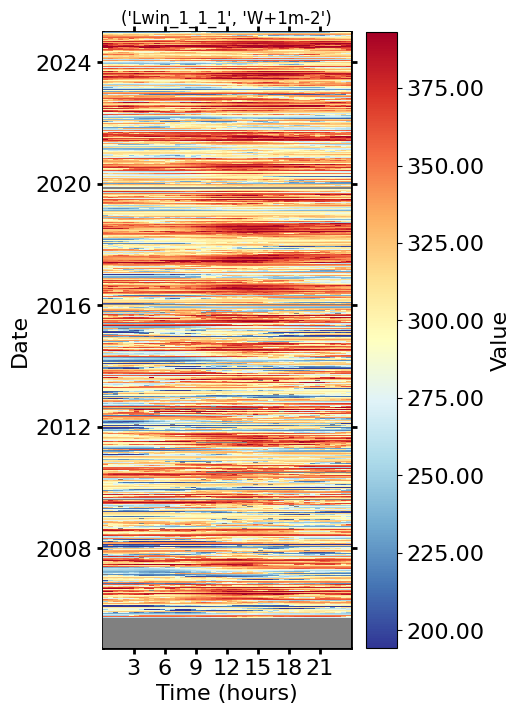

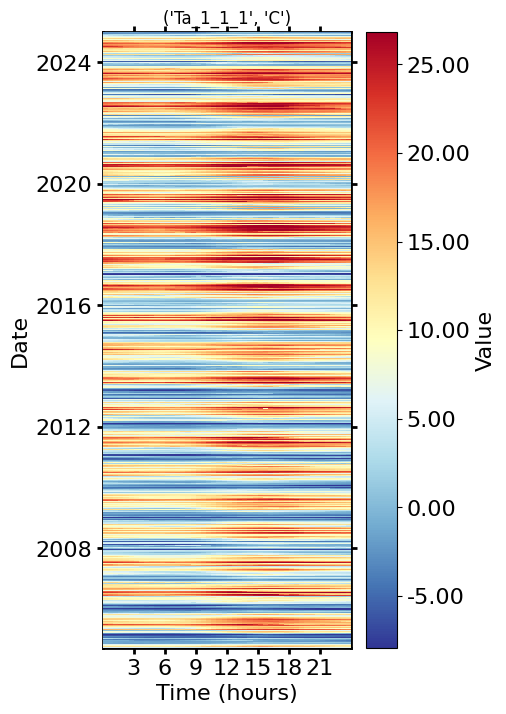

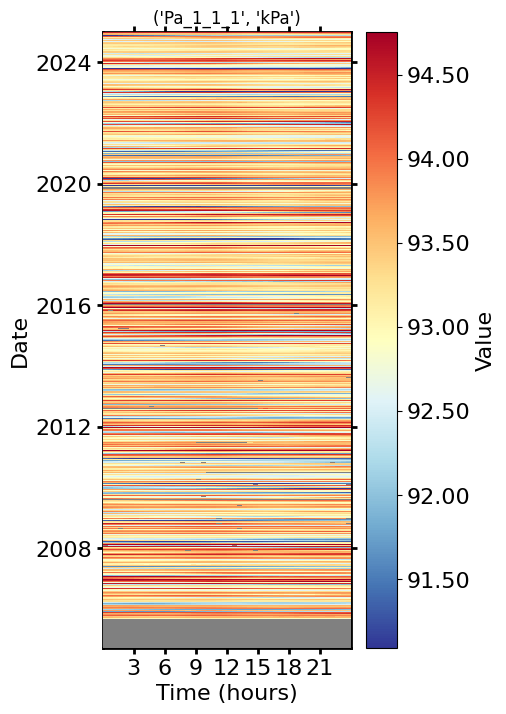

In [20]:
plotcols = [plotcol for plotcol in res.columns if not "TIMESTAMP" in plotcol[0]]
plotdf = res[plotcols].copy()

for col in plotdf.columns:
    series = plotdf[col].copy()
    series.replace(to_replace=-9999, value=np.nan, inplace=True)
    try:
        fig = plt.figure(facecolor='white', figsize=(4, 8))
        gs = gridspec.GridSpec(1, 1)  # rows, cols
        ax = fig.add_subplot(gs[0, 0])
        vmin = series.quantile(.01)
        vmax = series.quantile(.99)
        HeatmapDateTime(ax=ax, series=series, vmin=vmin, vmax=vmax).plot()
        ax.set_title(col, color='black')
        fig.show()
    except TypeError:
        pass

</br>

# **Save to CSV**

In [21]:
res.to_csv("CH-LAE_2004-2024_meteo_aux.csv", index=False)

</br>

# **End of notebook**

In [22]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-06-13 17:29:48
